In [4]:
"""Sentiment Analysis, Naive Bayes
Group members: Michael (Zeyu) Li (zl310) and Chengyang Zhou (cz169)"""

# referred to this https://github.com/DrManishSharma/NLP/blob/master/SentiAnalysis.ipynb
import matplotlib.pyplot as plt

import numpy as np
from sklearn.naive_bayes import GaussianNB, MultinomialNB
from sklearn.feature_extraction.text import CountVectorizer
from sklearn.model_selection import train_test_split


from nltk.tokenize import RegexpTokenizer

import pandas as pd

dataset = df = pd.read_csv('./IMDBDataset.csv')
# dataset = pd.read_csv('./IMDB_synthetic_final.csv')
token = RegexpTokenizer(r'[a-zA-Z0-9]+')
cv = CountVectorizer(stop_words='english', ngram_range=(1, 1), tokenizer=token.tokenize)
text_counts = cv.fit_transform(dataset['review'])
# print(dataset['review'][0])
# print(text_counts[0])

def return_test_score(test_frac):
    X_train, X_test, Y_train, Y_test = train_test_split(text_counts, dataset['sentiment'], test_size=test_frac, random_state=5)
    MNB = MultinomialNB()
    MNB.fit(X_train, Y_train)
    return MNB.score(X_test, Y_test)


def return_test_score_arr(start, end, num):
    test_f = np.linspace(start, end, num=num)
    test_acc = []
    for idx, frac in enumerate(test_f):
        test_acc.append(return_test_score(test_frac=frac))
    return test_f, test_acc


return_test_score_arr(0.3, 0.3, 1)
fig, ax = plt.subplots(1, 1)
test_frac, test_accuracy = return_test_score_arr(0.05, 0.95, 19)
ax.plot(test_frac, test_accuracy)
ax.set_xlabel("Test Fraction")
ax.set_ylabel("Test Accuracy")
fig.tight_layout()
plt.savefig("Figures/naiveBayes.pdf", dpi=500, bbox_inches='tight')

/home/zl310/anaconda3/envs/michael_ece684/lib/python3.8/site-packages/sklearn/feature_extraction/text.py:525: UserWarning: The parameter 'token_pattern' will not be used since 'tokenizer' is not None'
  warnings.warn(


(array([0.3]), [0.8568666666666667])

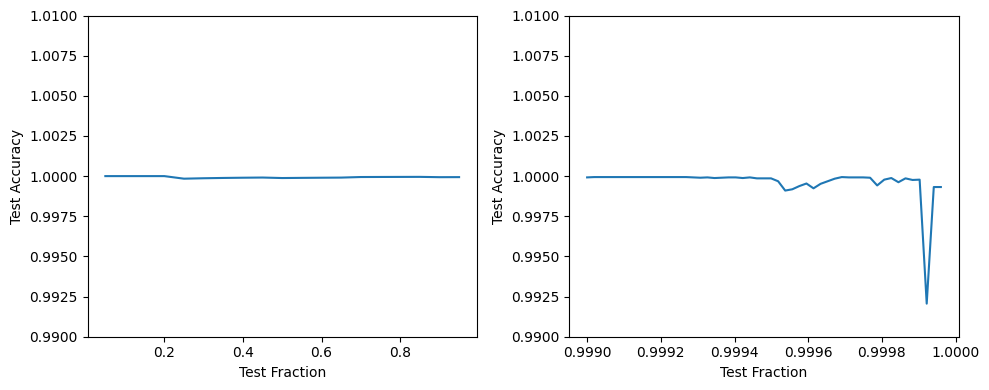

In [21]:
fig, ax = plt.subplots(1, 2, figsize=(10, 4))
test_frac, test_accuracy = return_test_score_arr(0.05, 0.95, 19)
ax[0].plot(test_frac, test_accuracy)
ax[0].set_xlabel("Test Fraction")
ax[0].set_ylabel("Test Accuracy")
ax[0].set_ylim([0.99, 1.01])

test_frac, test_accuracy = return_test_score_arr(0.999, 0.99996, 51)
ax[1].plot(test_frac, test_accuracy)
ax[1].set_xlabel("Test Fraction")
ax[1].set_ylabel("Test Accuracy")
ax[1].set_ylim([0.99, 1.01])
fig.tight_layout()
plt.savefig("Figures/synth_naiveBayes.pdf", dpi=500, bbox_inches='tight')

In [ ]:
# # the thre cells below are for cleaning up the data

# import pandas as pd
# # df = pd.read_csv('./IMDB_synthetic.csv')
# df = pd.read_csv('./IMDB_synthetic_final.csv')
# print(df.keys())
# print(sum(df['sentiment'] == 'negative'))
# print(sum(df['sentiment'] == 'positive'))


# fptr = open('IMDB_synthetic_final.csv', 'w')
# fptr.write("review,sentiment\n")
# j = 0
# for i in range(len(df['sentiment'])):
#     if (df.iloc[i, 1] == 'positive'):
#         fptr.write("\"%s\",%s\n" % (df.iloc[i, 0], df.iloc[i, 1]))
#         j += 1
#     if j >= 25000: break
# j = 0
# for i in range(len(df['sentiment'])):
#     if (df.iloc[i, 1] == 'negative'):
#         j += 1
#         fptr.write("\"%s\",%s\n" % (df.iloc[i, 0], df.iloc[i, 1]))
#     if j >= 25000: break

In [2]:
# # # df = pd.read_csv('./IMDB_synthetic.csv')
# df = pd.read_csv('./IMDB_synthetic_final.csv')
# print(df.keys())
# print(sum(df['sentiment'] == 'negative'))
# print(sum(df['sentiment'] == 'positive'))


Index(['review', 'sentiment'], dtype='object')
25000
25000


In [ ]:
# import pandas as pd
# df = pd.read_csv('./IMDB_synthetic.csv')
# fptr = open('IMDB_synthetic_final.csv', 'w')
# fptr.write("review,sentiment\n")
# for i in range(len(df['review'])):
#     # print(df['review'][i])
#     if len(str(df['review'][i]).split(" ")) > 10 and (df.iloc[i, 1]== 'positive' or df.iloc[i, 1] == 'negative'):
#         fptr.write("\"%s\",%s\n" % (df.iloc[i, 0], df.iloc[i, 1]))
#     if not (df.iloc[i, 1]== 'positive' or df.iloc[i, 1] == 'negative'):
#         print('wtf')